In [1]:
# 1.) Generate sequence of length k using Student model
# 2.) Evaluate drafted sequence using Teacher model
# 3.) Evaluate drafted sequence using Student model
# 4.) Calculate loss
# 5.) Backprop

In [1]:
from transformers import AutoTokenizer, T5ForConditionalGeneration
from transformers.utils import logging
import matplotlib.pyplot as plt
from datasets import load_dataset
import accelerate

logging.set_verbosity_error()

import torch
from torch.utils.data import DataLoader

In [ ]:
student_model_id = "google/flan-t5-small"
teacher_model_id = "google/flan-t5-xl"

tokenizer = AutoTokenizer.from_pretrained(student_model_id)
pad_token_id = tokenizer.pad_token_id
eos_token_id = tokenizer.eos_token_id

student = T5ForConditionalGeneration.from_pretrained(
    student_model_id,
    torch_dtype=torch.float16,
    device_map="cuda:0",
)
student.config.pad_token_id = pad_token_id
student.config.eos_token_id = eos_token_id

teacher = T5ForConditionalGeneration.from_pretrained(
    teacher_model_id,
    torch_dtype=torch.float16,
    max_memory={0: "2GiB", 1: "7Gib"},
    device_map="auto",
).eval()
teacher.config.pad_token_id = pad_token_id
teacher.config.eos_token_id = eos_token_id

In [3]:
ds = load_dataset("openai/gsm8k", "main")
ds_train = ds["train"]
ds_test = ds["test"]

In [4]:
def build_prompt(prompt):
    return "\n".join(
        [
            "Solve the problem. Show your reasoning.",
            "At the end, write: Final Answer: <number>\n",
            f"Q: {prompt}\nA: Let's think step by step.\n",
        ]
    )


def tokenize_function(examples, tokenizer, max_length):
    return tokenizer(
        build_prompt(examples["question"]),
        padding="max_length",
        max_length=max_length,
        return_tensors="pt",
    )


tokenized_dataset = ds_train.map(
    tokenize_function,
    fn_kwargs={"tokenizer": tokenizer, "max_length": 256},
    batched=False,
    remove_columns=ds_train.column_names,
)

# 2) Tell datasets to return torch tensors on indexing
tokenized_dataset = tokenized_dataset.with_format(
    type="torch",
    columns=["input_ids", "attention_mask"],
)

In [5]:
# Will use this for training loop
dl = DataLoader(tokenized_dataset, batch_size=16, shuffle=True, drop_last=True)

In [6]:
# 1. Generate sequence with length k from Student model
k = 256

# Sample per iteration
# torch.distributions.uniform.Uniform(0.75, 1.25).sample()

for batch in dl:
    with torch.no_grad():
        outputs = student.generate(
            input_ids=batch["input_ids"].squeeze(1).to(student.device),
            attention_mask=batch["attention_mask"].squeeze(1).to(student.device),
            max_new_tokens=k,
            do_sample=False,
            use_cache=True,
            return_dict_in_generate=False,
            output_scores=False,
        )
    break

In [ ]:
print(tokenizer.decode(batch["input_ids"][0, 0, :]))
print(tokenizer.decode(outputs[0]))

In [8]:
# 2.) Evaluate drafted sequence using Teacher model
# Use up to k-1, teacher and student will predict next token (we already have the label)
with torch.no_grad():
    logits_t = teacher(
        input_ids=batch["input_ids"].squeeze(1).to(student.device),
        attention_mask=batch["attention_mask"].squeeze(1).to(student.device),
        decoder_input_ids=outputs,
    ).logits[:, :-1, :]

In [9]:
# 3.) Evaluate drafted sequence using Student model
logits_s = student(
    input_ids=batch["input_ids"].squeeze(1).to(student.device),
    attention_mask=batch["attention_mask"].squeeze(1).to(student.device),
    decoder_input_ids=outputs,
).logits[:, :-1, :]

In [10]:
# 4.) Calculate loss
T = 1.0
logp_s = torch.log_softmax(logits_s / T, dim=-1)
p_t = torch.softmax(logits_t / T, dim=-1)
kd_tok = torch.nn.functional.kl_div(logp_s, p_t, reduction="none") * (T * T)
kd_seq = kd_tok.sum(dim=-1)
loss = kd_seq.mean()

In [11]:
# 5.) Backprop
loss.backward()

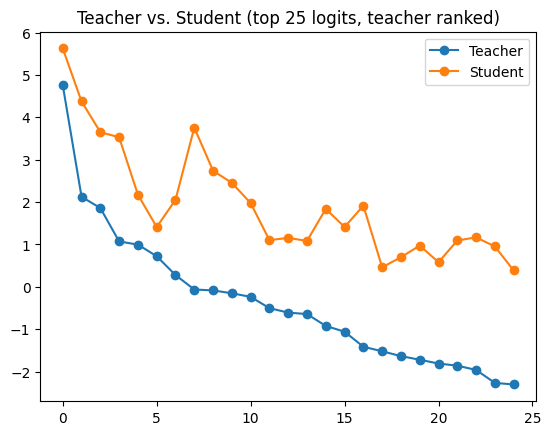

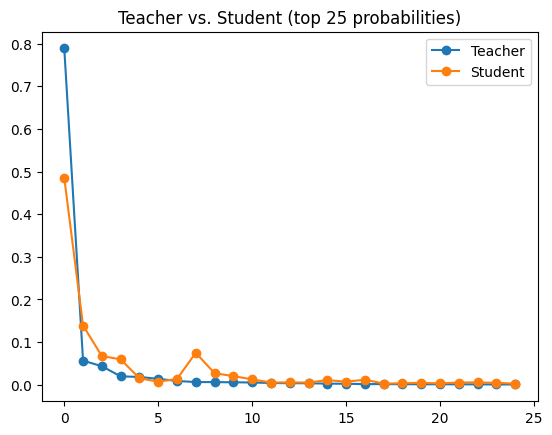

In [12]:
N = 25
topN_t, topN_idx = torch.topk(logits_t.cpu(), N)
topN_s = torch.gather(logits_s.detach().cpu(), dim=2, index=topN_idx)

plt.title(f"Teacher vs. Student (top {N} logits, teacher ranked)")
plt.plot(topN_t[0, 0, :], "-o", label="Teacher")
plt.plot(topN_s[0, 0, :], "-o", label="Student")
plt.legend()
plt.show()

plt.title(f"Teacher vs. Student (top {N} probabilities)")
plt.plot(torch.softmax(topN_t[0, 0, :], dim=-1), "-o", label="Teacher")
plt.plot(torch.softmax(topN_s[0, 0, :], dim=-1), "-o", label="Student")
plt.legend()
plt.show()

In [13]:
logits_t.shape

torch.Size([16, 256, 32128])